In [3]:
import cv2
import src.process_func as pf
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline
plt.rcParams['figure.figsize'] = (12.0, 12.0)
plt.rcParams['image.interpolation'] = 'nearest'

param_path = 'data/param/'
template_path = 'data/templates/'
scene_path = 'data/templates/'
src_path = 'data/templates/'

template_filename = template_path + 'template.jpg'
scene_filename = scene_path + 'scene.jpg'
src_filename = src_path + 'template1.jpg'
camera_params_filename = param_path + 'cam_params.npz'

cam_params = np.load(camera_params_filename)
camera_matrix = cam_params['camera_matrix']
dist_coefs = cam_params['dist_coefs']

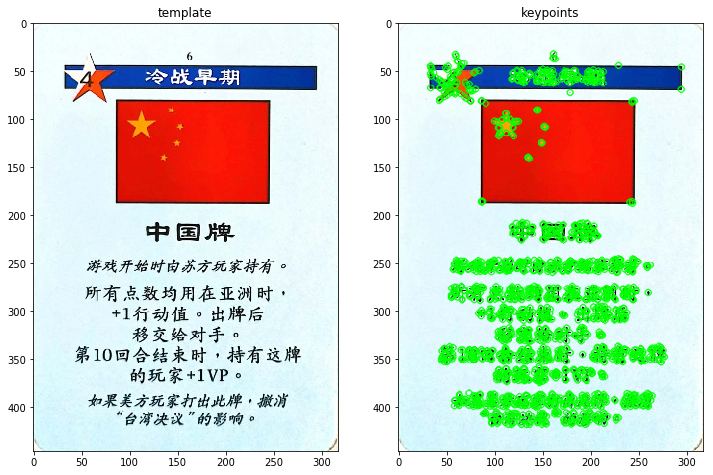

In [4]:
template = cv2.imread(template_filename)

# BRISK keypoint detector
brisk = cv2.BRISK_create()

# 用BRISK detector找到keypoint及descriptor
kp = brisk.detect(template, None)
kp, des = brisk.compute(template, kp)

# draw keypoints
img2 = template.copy()
img2 = cv2.drawKeypoints(img2, kp, img2, color=(0,255,0), flags=0)
plt.subplot(1,2,1)
plt.imshow(cv2.cvtColor(template, cv2.COLOR_BGR2RGB))
plt.title('template')

plt.subplot(1,2,2)
plt.imshow(cv2.cvtColor(img2, cv2.COLOR_BGR2RGB))
plt.title('keypoints')

plt.show()

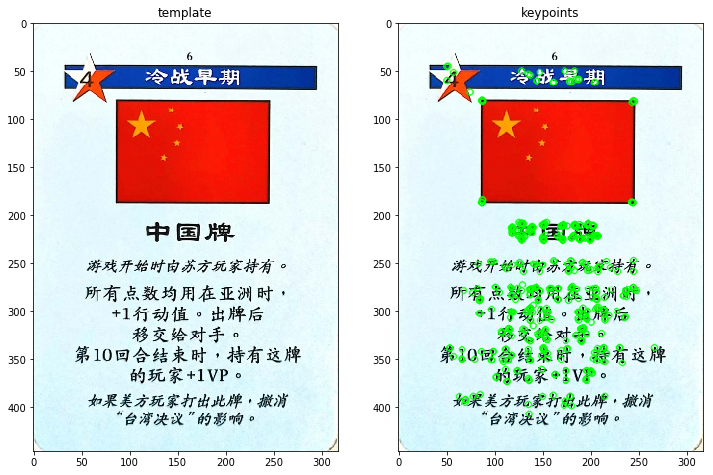

In [5]:
template = cv2.imread(template_filename)

# ORB keypoint detector
orb = cv2.ORB_create()

# 用ORB detector找到keypoint及descriptor
kp = orb.detect(template, None)
kp, des = orb.compute(template, kp)

# draw keypoints
img2 = template.copy()
img2 = cv2.drawKeypoints(img2, kp, img2, color=(0,255,0), flags=0)
plt.subplot(1,2,1)
plt.imshow(cv2.cvtColor(template, cv2.COLOR_BGR2RGB))
plt.title('template')

plt.subplot(1,2,2)
plt.imshow(cv2.cvtColor(img2, cv2.COLOR_BGR2RGB))
plt.title('keypoints')

plt.show()

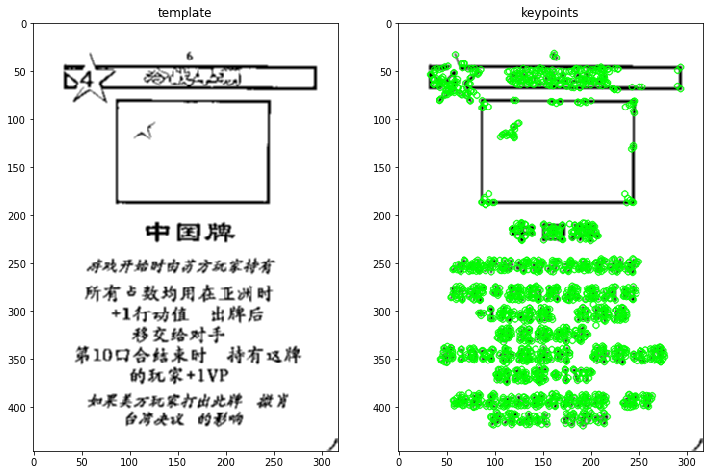

In [7]:
template = cv2.imread(template_filename)

# 缩小图片尺寸以减少运算量
scale_factor = 0.25
img1 = pf.image_proc(template, scale_factor)

# BRISK keypoint detector
brisk = cv2.BRISK_create()

# 用BRISK detector找到keypoint及descriptor
kp = brisk.detect(img1, None)
kp, des = brisk.compute(img1, kp)

# draw keypoints
img2 = img1.copy()
img2 = cv2.drawKeypoints(img2, kp, img2, color=(0,255,0), flags=0)
plt.subplot(1,2,1)
plt.imshow(cv2.cvtColor(img1, cv2.COLOR_BGR2RGB))
plt.title('template')

plt.subplot(1,2,2)
plt.imshow(cv2.cvtColor(img2, cv2.COLOR_BGR2RGB))
plt.title('keypoints')

plt.show()

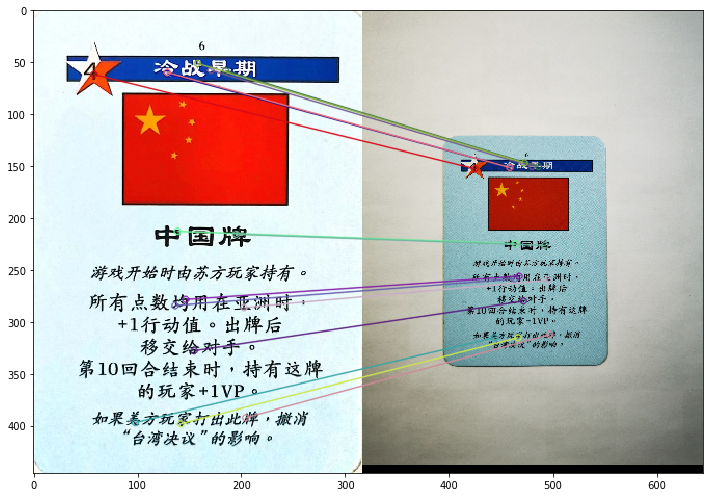

In [5]:
MIN_MATCHES = 15
scene = cv2.imread(scene_filename)    
model = cv2.imread(template_filename)
scene = cv2.resize(scene, None, fx=0.12, fy=0.12)
# BRISK keypoint detector
brisk = cv2.BRISK_create()              
index_params = dict(algorithm=6,
                    table_number=6,  # 12
                    key_size=12,  # 20
                    multi_probe_level=1)  # 2
search_params = dict(checks=1) 

flann = cv2.FlannBasedMatcher(index_params, search_params)

# 用BRISK detector找到模板图片和及照片的keypoint及descriptor
kp_model, des_model = brisk.detectAndCompute(model, None)  
kp_frame, des_frame = brisk.detectAndCompute(scene, None)

# 将模板图片和及照片的descriptor相对应，并根据distance进行排序
matches = flann.match(des_model, des_frame)
matches = sorted(matches, key=lambda x: x.distance)

if len(matches) > MIN_MATCHES:
    # first 15 matches.
    match = cv2.drawMatches(model, kp_model, scene, kp_frame,
                          matches[:MIN_MATCHES], 0, flags=2)
    # 比对结果
    plt.imshow(cv2.cvtColor(match, cv2.COLOR_BGR2RGB))
    plt.show()
else:
    print (("Not enough matches have been found - %d/%d") % (len(matches), MIN_MATCHES))
     

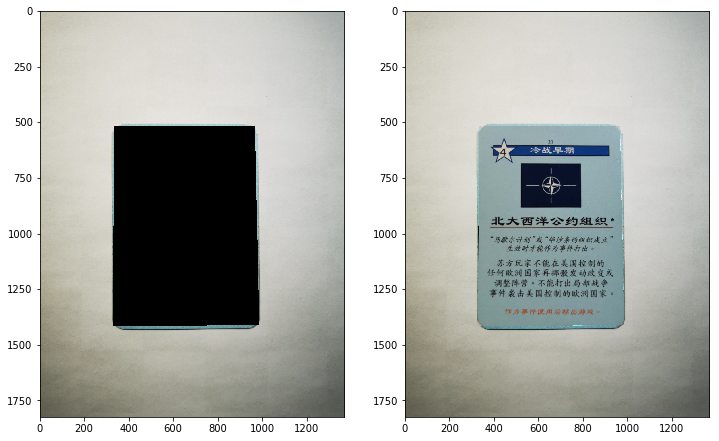

In [6]:
template = cv2.imread(template_filename)
# 缩小图片尺寸以减少运算量
scale_factor = 0.25
img1 = pf.image_proc(cv2.resize(template,(540,960)),scale_factor)

scene = cv2.imread(scene_filename)   
img_resize = cv2.resize(scene, None, fx=0.5, fy=0.5)
img2 = pf.image_proc(img_resize, 0.5)

dst_pts, dst = pf.brisk_flann(img1, img2)
# BRISK keypoint detector
brisk = cv2.BRISK_create()
# 用BRISK detector找到模板图片和及视频帧的keypoint及descriptor
kp1, des1 = brisk.detectAndCompute(img1, None)
kp2, des2 = brisk.detectAndCompute(img2, None)

# FLANN parameters
FLANN_INDEX_LSH = 1
index_params = dict(algorithm=6,
                    table_number=6,  # 12
                    key_size=12,  # 20
                    multi_probe_level=1)  # 2
search_params = dict(checks=1) 

# FLANN特征匹配
flann = cv2.FlannBasedMatcher(index_params, search_params)
matches = flann.knnMatch(des1, des2, k=2)
# 判断是否为好的匹配
good = []
for m, n in matches:
    if m.distance < 0.7 * n.distance:
        good.append(m)

src_pts = np.float32([kp1[m.queryIdx].pt for m in good]).reshape(-1, 1, 2)
dst_pts = np.float32([kp2[m.trainIdx].pt for m in good]).reshape(-1, 1, 2)
M, mask = cv2.findHomography(src_pts, dst_pts, cv2.RANSAC, 10.0)

img_target = cv2.imread(src_filename)   
img_target = cv2.resize(img_target,(540,960))
# 利用Homography矩阵进行投影
imgWarp = cv2.warpPerspective(img_target,M,(img_resize.shape[1],img_resize.shape[0]))
# 降噪，去掉最大或最小的像素点
retval, threshold_img = cv2.threshold(imgWarp, 0, 255, cv2.THRESH_BINARY)
imgWarp = imgWarp + threshold_img

whiteMask = np.zeros((img_resize.shape[0],img_resize.shape[1]),np.uint8)
cv2.fillPoly(whiteMask,[np.int32(dst)],(255,255,255))   
blackMask = cv2.bitwise_not(whiteMask)

img_mask = cv2.bitwise_and(img_resize,img_resize,mask=blackMask)
img_resize = cv2.bitwise_or(img_mask,imgWarp)

plt.subplot(1,2,1)
plt.imshow(cv2.cvtColor(img_mask, cv2.COLOR_BGR2RGB))

plt.subplot(1,2,2)
plt.imshow(cv2.cvtColor(img_resize, cv2.COLOR_BGR2RGB))

plt.show()

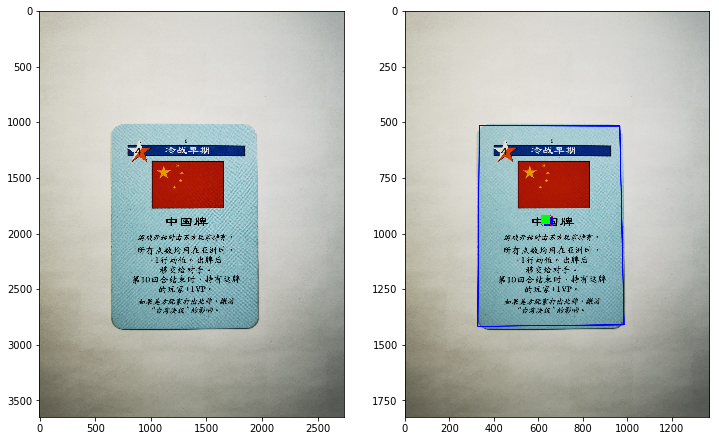

In [7]:
template = cv2.imread(template_filename)
# 缩小图片尺寸以减少运算量
scale_factor = 0.25
img1 = pf.image_proc(cv2.resize(template,(540,960)),scale_factor)

scene = cv2.imread(scene_filename)   
img_resize = cv2.resize(scene, None, fx=0.5, fy=0.5)
img2 = pf.image_proc(img_resize, 0.5)

dst_pts, dst = pf.brisk_flann(img1, img2)
# 在图片中框出模板匹配的区域
img_marked = pf.draw_frame(img_resize, dst)

src_pts = np.copy(dst_pts)
img3 = np.copy(img2)

lk_params = dict( winSize  = (15,15),
                  maxLevel = 2,
                  criteria = (cv2.TERM_CRITERIA_EPS | cv2.TERM_CRITERIA_COUNT, 10, 0.03))
dst_pts, st, err = cv2.calcOpticalFlowPyrLK(img3, img2, src_pts, None, **lk_params)
good_new = dst_pts[st == 1]
good_old = src_pts[st == 1]

M = pf.computeHomography(good_old, good_new)

# 利用Homography矩阵转换frame的边界
dst = cv2.perspectiveTransform(dst, M)

# 3D世界角点坐标
pg_points = np.array([
    (93.0, 135.0, 0.0),  # 1
    (93.0, -135.0, 0.0),  # 2
    (-93.0, -135.0, 0.0),  # 3
    (-93.0, 135.0, 0.0)  # 4
])
dst = cv2.perspectiveTransform(dst, M)
ret, rvecs, tvecs, inlier_pt = cv2.solvePnPRansac(pg_points, dst, camera_matrix, dist_coefs)
img_marked = pf.plot_cube(img_marked, rvecs, tvecs, camera_matrix, dist_coefs)

plt.subplot(1,2,1)
plt.imshow(cv2.cvtColor(scene, cv2.COLOR_BGR2RGB))

plt.subplot(1,2,2)
plt.imshow(cv2.cvtColor(img_marked, cv2.COLOR_BGR2RGB))

plt.show()